<a href="https://colab.research.google.com/github/ScientistLim/ProjectAW/blob/main/univariate_tft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 설치
!pip install torch numpy scikit-learn matplotlib pytorch-lightning pytorch-forecasting

# 데이터 불러오기 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE
from torch.optim import Adam
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# 데이터 로드
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

# 스케일링
scaler = MinMaxScaler()
df_train['feed_pressure'] = scaler.fit_transform(df_train[['feed_pressure']])
df_test['feed_pressure'] = scaler.transform(df_test[['feed_pressure']])

# 시간 인덱스 추가
df_train['time_idx'] = range(len(df_train))
df_test['time_idx'] = range(len(df_train), len(df_train) + len(df_test))

# 학습 및 테스트 데이터 병합
df_total = pd.concat([df_train, df_test], ignore_index=True)

# TimeSeriesDataSet 정의
max_encoder_length = 60  # 입력 시퀀스 길이
max_prediction_length = 30  # 예측 시퀀스 길이

# 그룹 ID를 "time_idx" 대신 고유한 그룹으로 설정
df_total["group"] = "series"  # 단일 시계열일 경우 고유 그룹 지정

training = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx < len(df_train)],  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],  # 그룹 ID를 "time_idx"에서 "group"으로 변경
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 변화를 알 수 있는 변수
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

# 학습 및 검증 데이터셋 생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=32, num_workers=0)

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,
    loss=RMSE()
)

from torch.optim import Adam

# TFT 모델을 LightningModule로 감싸기 위한 클래스 정의
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)[0]  # `y_hat`에서 첫 번째 요소만 가져오기
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)[0]  # `y_hat`에서 첫 번째 요소만 가져오기
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.03)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]

# TFT 모델을 TFTWrapper로 감싸기
wrapped_tft = TFTWrapper(tft)

# Trainer 설정
trainer = Trainer(
    accelerator="cpu",  # GPU가 없을 경우 CPU로 설정
    devices=1,
    max_epochs=10,
    gradient_clip_val=0.1
)

# 학습 실행
trainer.fit(
    model=wrapped_tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


ValueError: too many values to unpack (expected 2)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


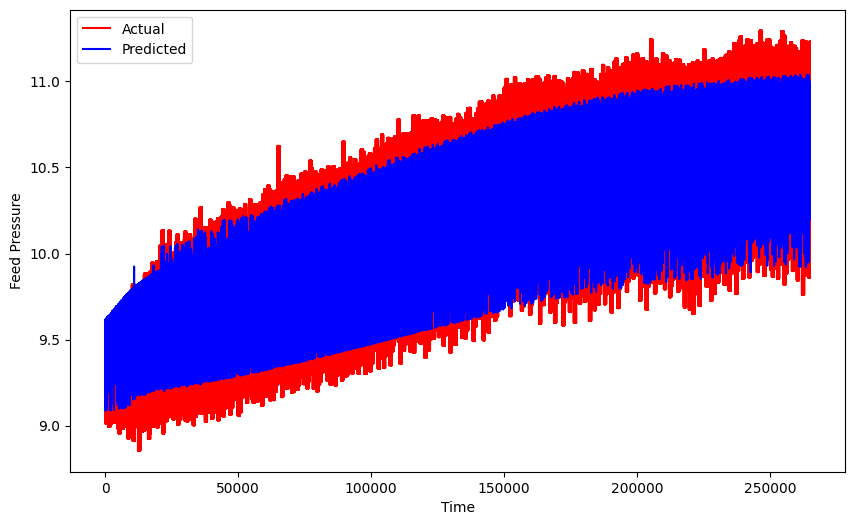

Root Mean Squared Error (RMSE): 0.2271659
R^2 (Coefficient of Determination): 0.8104017376899719
Mean Absolute Percentage Error (MAPE): 1.5856891870498657 %


In [ ]:
# 예측 (변수 하나로 받기)
predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

# 필요한 값 추출
raw_predictions = predictions[0]  # 첫 번째 반환 값은 raw_predictions
x = predictions[1]                # 두 번째 반환 값은 x

# 예측값 복원
predicted = scaler.inverse_transform(raw_predictions["prediction"][:, :, 0].cpu().numpy())
actual = scaler.inverse_transform(x["decoder_target"].cpu().numpy())

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(actual.flatten(), label="Actual", color="red")
plt.plot(predicted.flatten(), label="Predicted", color="blue")
plt.xlabel("Time")
plt.ylabel("Feed Pressure")
plt.legend()
plt.show()

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import numpy as np

# 기존 평가 지표 계산
rmse = np.sqrt(mean_squared_error(actual.flatten(), predicted.flatten()))
r2 = r2_score(actual.flatten(), predicted.flatten())
mape = mean_absolute_percentage_error(actual.flatten(), predicted.flatten()) * 100

# Pearson Correlation Coefficient 계산
pcc, _ = pearsonr(actual.flatten(), predicted.flatten())

# Mean Bias Deviation (MBD) 계산
mbd = np.mean(predicted.flatten() - actual.flatten())

# Mean Absolute Error of Means (MAEM) 계산
maem = abs(np.mean(predicted.flatten()) - np.mean(actual.flatten()))

# 결과 출력
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 (Coefficient of Determination):", r2)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")
print("Pearson Correlation Coefficient (PCC):", pcc)
print("Mean Bias Deviation (MBD):", mbd)
print("Mean Absolute Error of Means (MAEM):", maem)